In [1]:
import os, sys

import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from utils.time_utils import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# base_dir = "/n/holylabs/LABS/idreos_lab/Users/azhao/gpu_profiling"
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"

# Confirm there are bands

16it [00:06,  2.35it/s]
100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


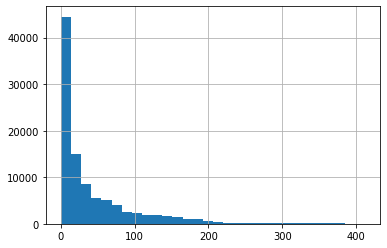

In [2]:
time_processor_sdpa = TimeProcessorSDPA(base_dir)
df = time_processor_sdpa.get_data(sample_rate=0.7)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

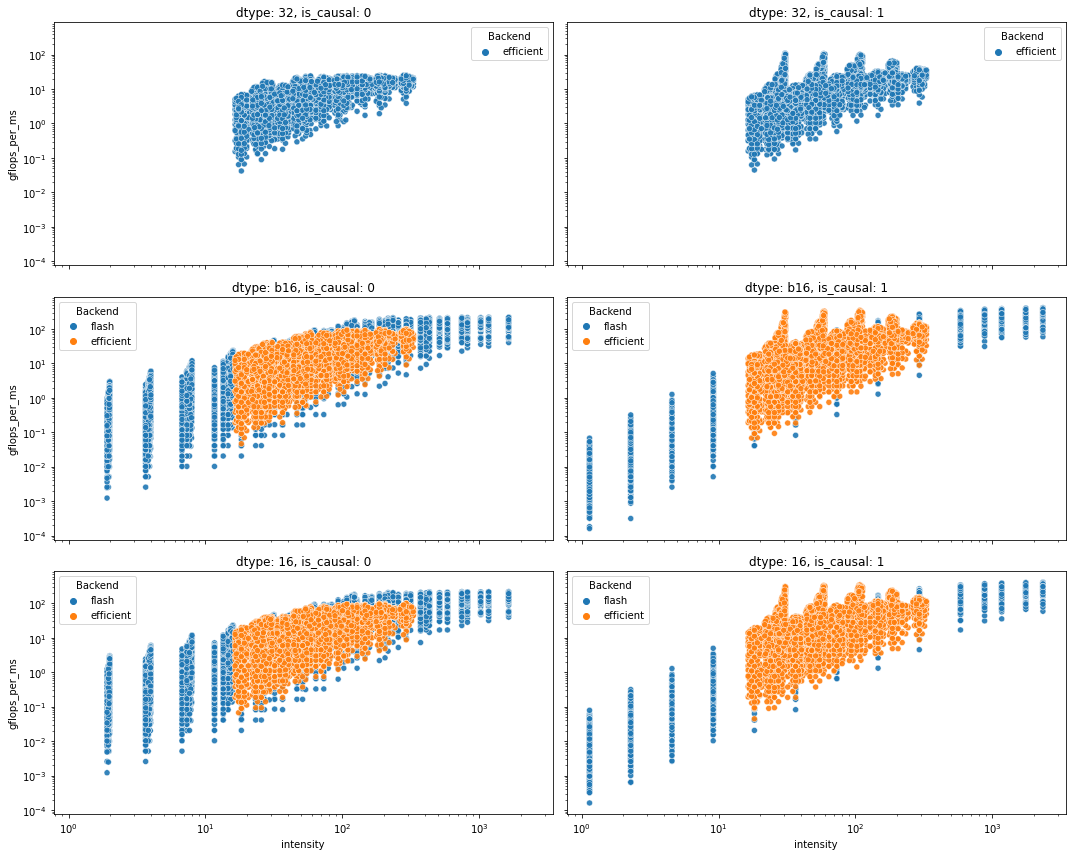

In [3]:
df["memory_accesses"] = (
    2 * df["b"] * df["h"] * df["s_q"] * df["d_qk"] +  # Reading Q
    2 * df["b"] * df["h"] * df["s_kv"] * df["d_qk"] +  # Reading K
    2 *df["b"] * df["h"] * df["s_kv"] * df["d_v"] +   # Reading V
    df["b"] * df["h"] * df["s_q"] * df["d_v"]      # Writing Output
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Look at one band

In [7]:
df.query("dtype == '16' and is_causal == '0'")["intensity"].value_counts()

intensity
73.142857     710
36.571429     699
146.285714    626
292.571429    600
585.142857    543
             ... 
91.428571       8
24.615385       8
59.534884       8
31.219512       7
22.857143       7
Name: count, Length: 311, dtype: int64

In [33]:
df_band1 = df.query("dtype == '16' and is_causal == '0' and 73.14 < intensity < 74.15")
df_band2 = df.query("dtype == '16' and is_causal == '0' and 36.57 < intensity < 36.58")
df_band = pd.concat([df_band1, df_band2], axis=0)
df_band

,kernel_params,dtype,backend,b,h,s_q,s_kv,d_qk,d_v,is_causal,time,gflops,gflops_per_ms,memory_accesses,intensity
42140,16.flash.4.4.512.64.224.224.0,16,flash,4,4,512,64,224,224,0,0.026624,0.469762,17.644308,6422528,73.142857
42154,16.flash.4.4.128.128.128.128.0,16,flash,4,4,128,128,128,128,0,0.026624,0.134218,5.041231,1835008,73.142857
42254,16.flash.64.4.512.64.176.176.0,16,flash,64,4,512,64,176,176,0,0.104960,5.905580,56.265055,80740352,73.142857
42274,16.flash.16.4.128.128.128.128.0,16,flash,16,4,128,128,128,128,0,0.026624,0.536871,20.164923,7340032,73.142857
42339,16.flash.16.4.128.128.192.192.0,16,flash,16,4,128,128,192,192,0,0.026624,0.805306,30.247385,11010048,73.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83463,16.efficient.32.16.64.64.256.256.0,16,efficient,32,16,64,64,256,256,0,0.062464,2.147484,34.379542,58720256,36.571429
83562,16.efficient.64.16.64.64.64.64.0,16,efficient,64,16,64,64,64,64,0,0.034816,1.073742,30.840470,29360128,36.571429
83907,16.efficient.16.16.64.64.256.256.0,16,efficient,16,16,64,64,256,256,0,0.035840,1.073742,29.959313,29360128,36.571429
83920,16.efficient.4.16.64.64.128.128.0,16,efficient,4,16,64,64,128,128,0,0.022528,0.134218,5.957818,3670016,36.571429


Why does this figure make sense? We plotted gflops / time vs. gflops / memory accesses.

Let's say gflops / memory_accesses = c => c * memory_accesses = gflops.

Interesting: memory_accesses increases linearly with time.

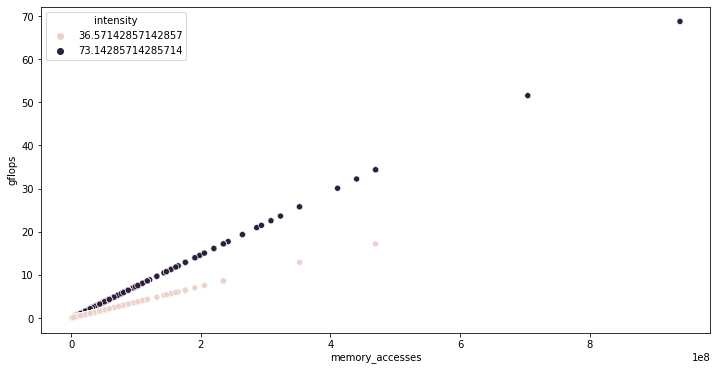

In [37]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x="memory_accesses", y="gflops", hue="intensity", data=df_band
)
plt.show()

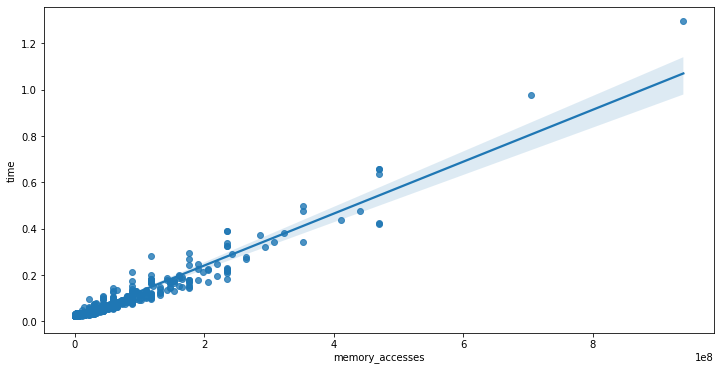

In [39]:
plt.figure(figsize=(12,6))
sns.regplot(
    x="memory_accesses", y="time", data=df_band
)
plt.show()

Not very informative

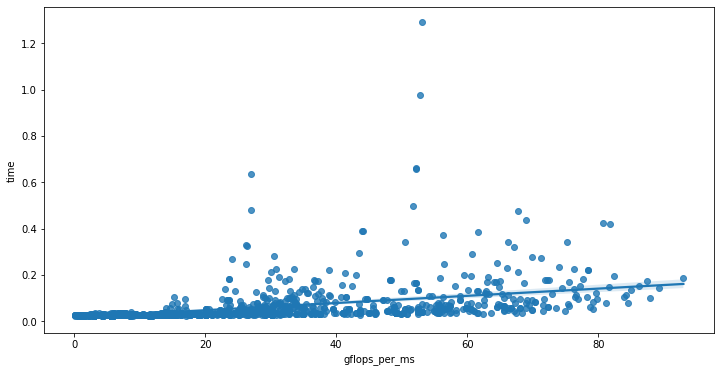

In [40]:
plt.figure(figsize=(12,6))
sns.regplot(
    x="gflops_per_ms", y="time", data=df_band
)
plt.show()

# On the entire df

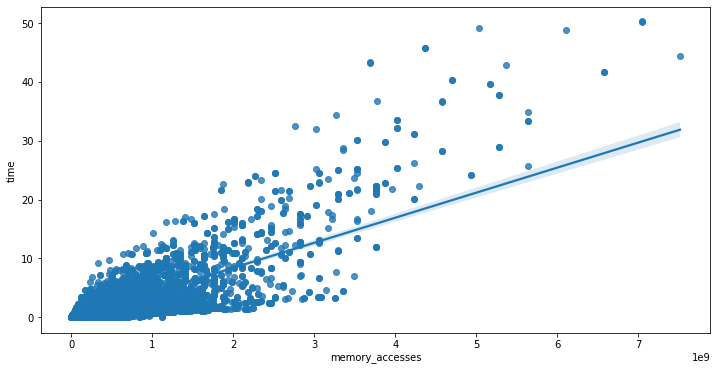

In [41]:
plt.figure(figsize=(12,6))
sns.regplot(
    x="memory_accesses", y="time", data=df
)
plt.show()